In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
from scipy.io import wavfile

import sys
import os
import soundfile as sf
from scipy.signal import resample

import cv2
from brian2 import *
# from brian2 import NeuronGroup

/home/arafat/.cython/brian_extensions/_cython_magic_27ec94d318d7d5d457bb08bed84f8a9e.cpp:47:10: fatal error: Python.h: No such file or directory
   47 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/x86_64-linux-gnu-gcc' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


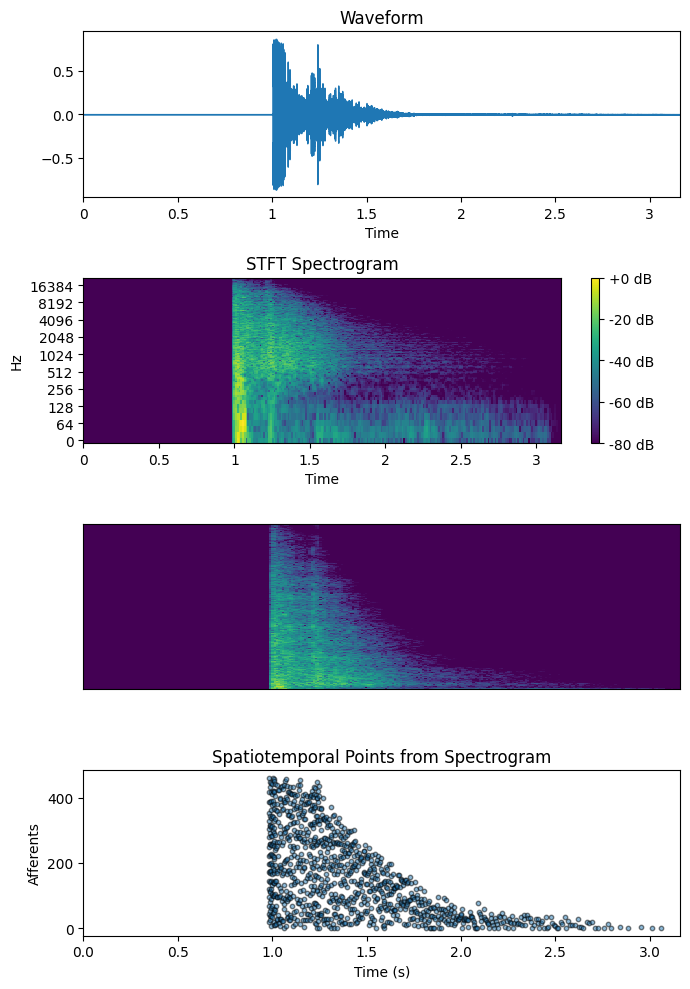

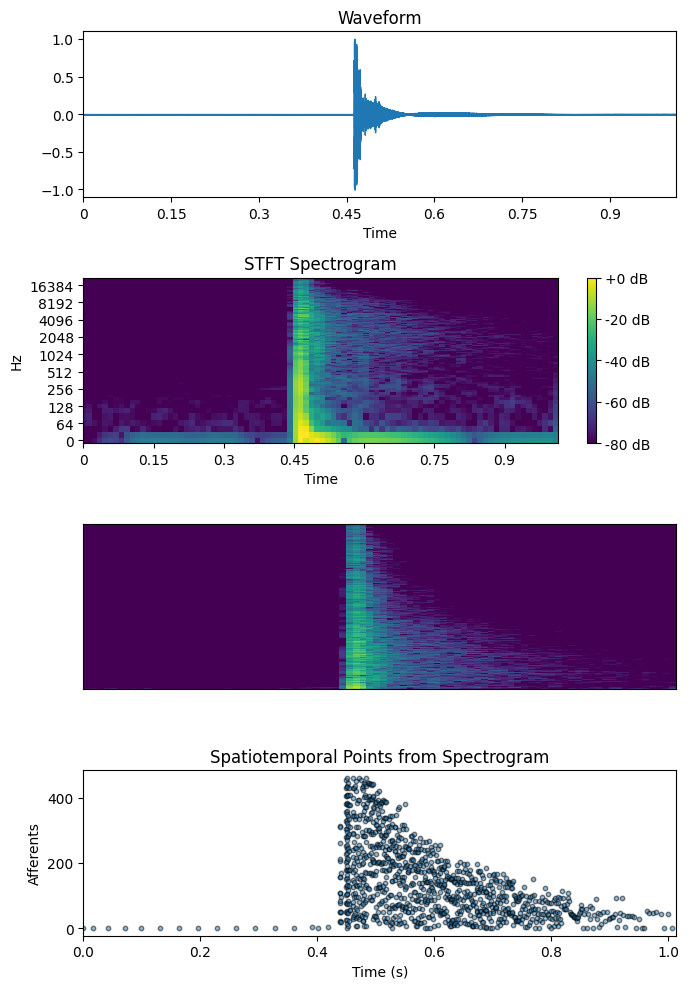

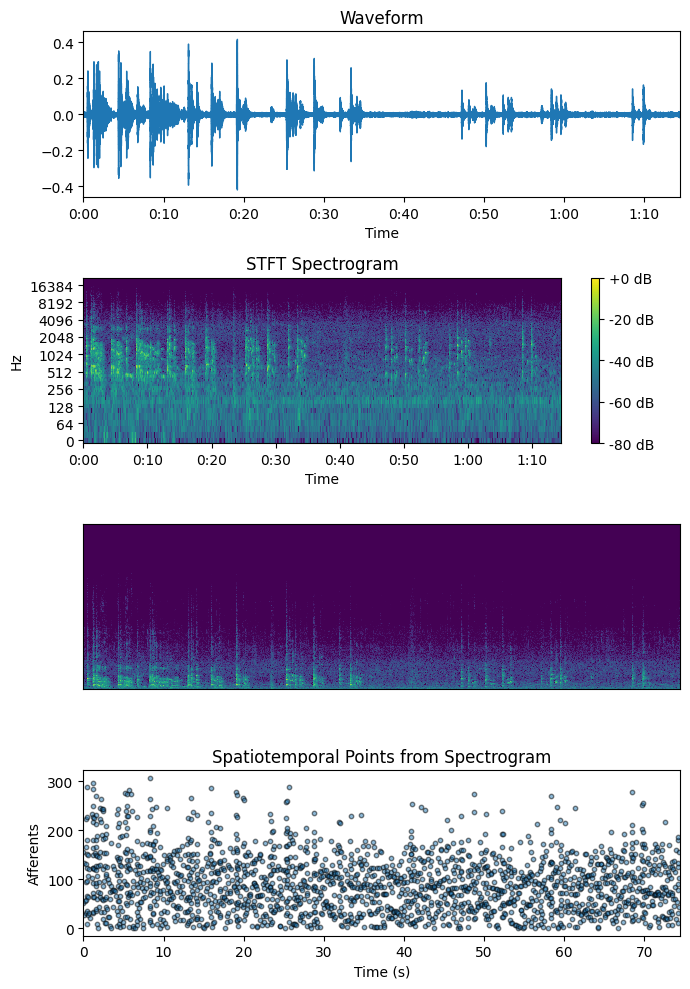

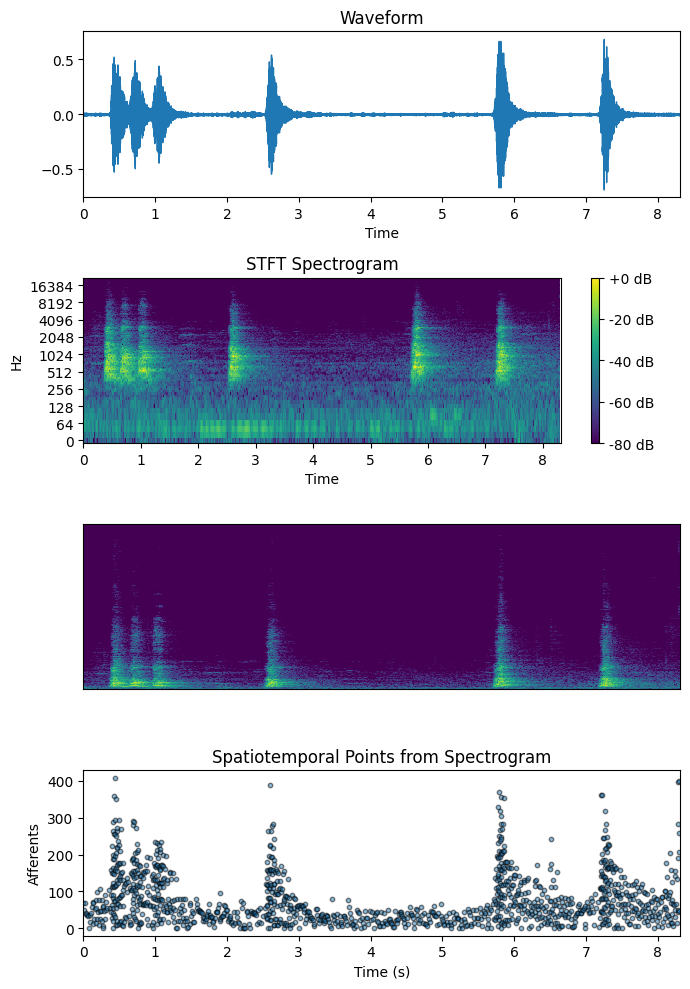

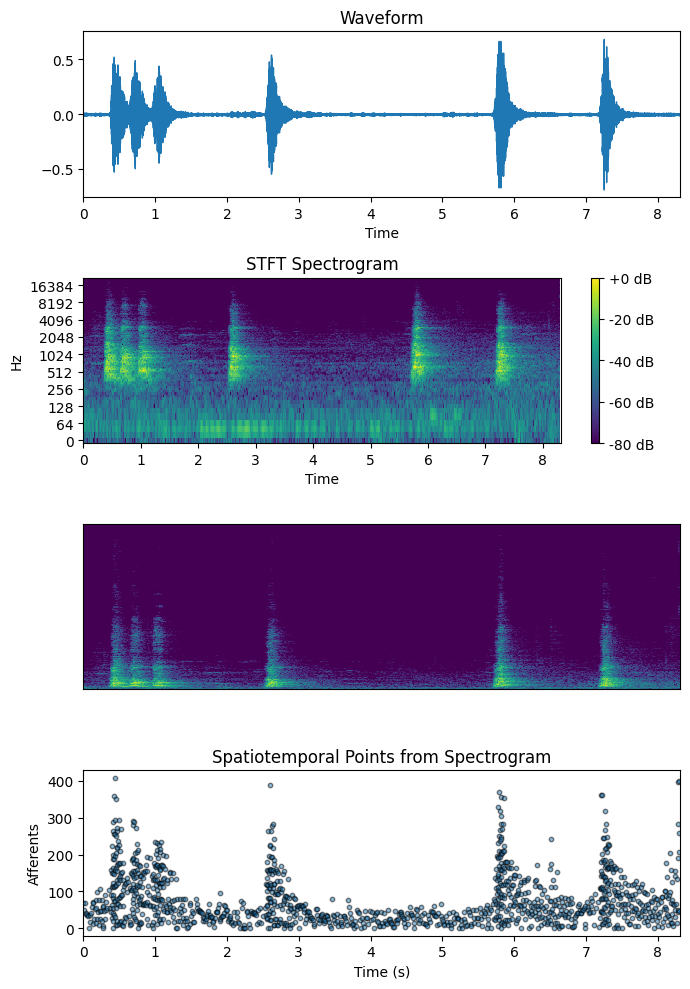

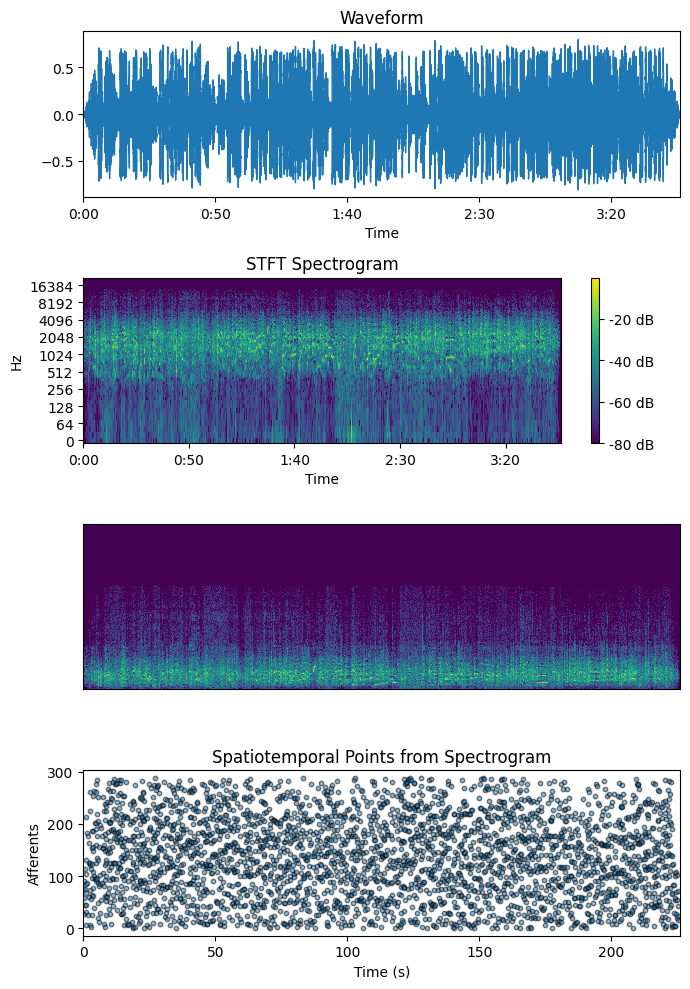

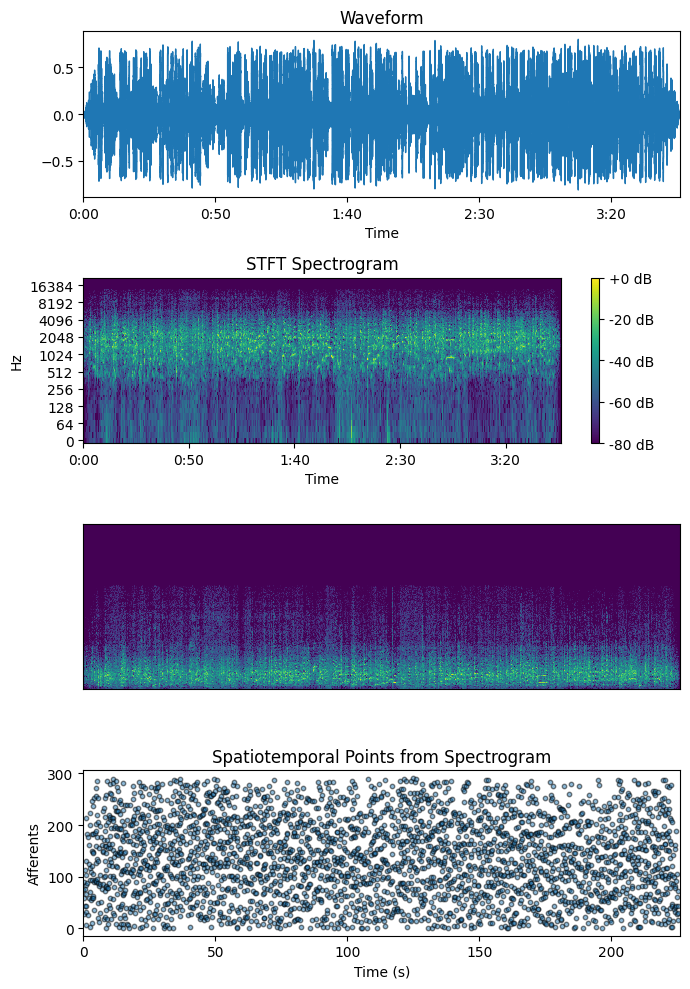

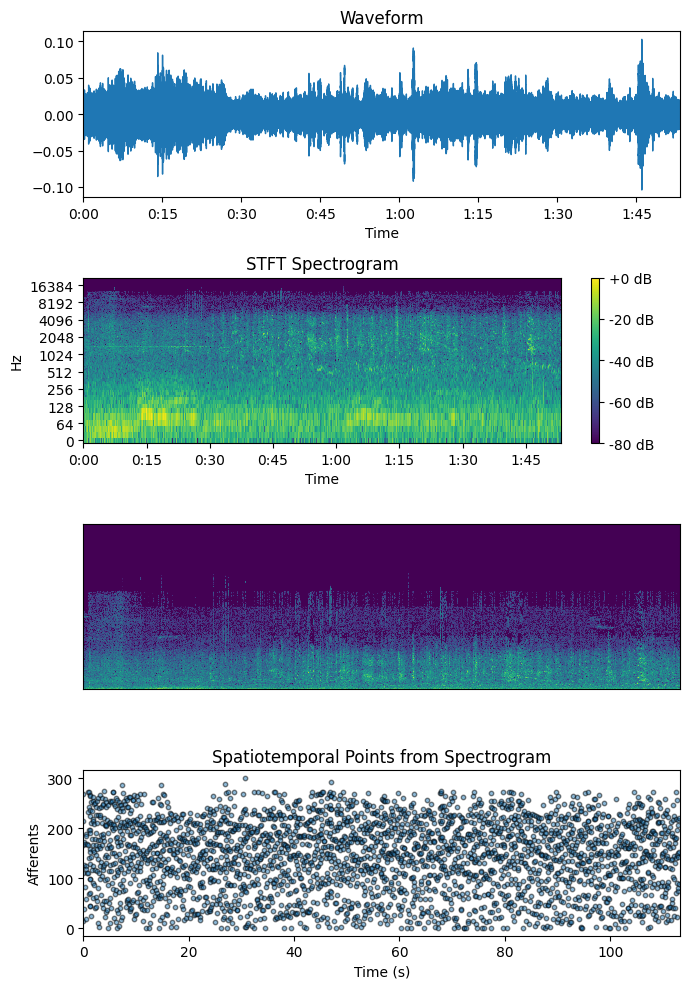

In [5]:
def plot_and_save_chirplet_transform(audio_path, chirplet_output_folder, combined_output_folder, spatiotemporal_output_folder):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Get the duration of the audio in seconds
    duration = librosa.get_duration(y=y, sr=sr)

    # Perform the Short-Time Fourier Transform (STFT)
    stft = librosa.stft(y)
    stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # Plot the STFT without axes and labels
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(stft_db, sr=sr, x_axis=None, y_axis=None, cmap="viridis")
    plt.axis("off")

    # Save the plot
    plot_filename_chirp = os.path.basename(audio_path).rsplit(".", 1)[0] + "_chirplet.png"
    plot_path_chirp = os.path.join(chirplet_output_folder, plot_filename_chirp)
    plt.savefig(plot_path_chirp, bbox_inches="tight", pad_inches=0)
    plt.close()


    #--------------------------------------------------------------------------------------------------------

    # Brian2 use
    # Load the chirplet transform spectrogram PNG image using OpenCV
    image = cv2.imread(plot_path_chirp, cv2.IMREAD_GRAYSCALE)
    image_data = image.astype(float) / 255.0
    height, width = image_data.shape

    time_duration = duration * second  # Use the actual audio duration
    num_neurons = height
    global_threshold = 0.09
    block_size = 19
    C = -5
    adaptive_thresh = cv2.adaptiveThreshold(
        (image_data * 255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
    )
    adaptive_thresh = adaptive_thresh / 255.0
    times = []
    neurons = []
    for ex in range(width):   # ex and why used to not conflict with x and y
        for why in range(height):
            if image_data[why, ex] > global_threshold and adaptive_thresh[why, ex] > 0:
                time_point = ex / width * time_duration
                neuron_point = why
                times.append(time_point)
                neurons.append(neuron_point)

    times = np.array(times) * second
    neurons = np.array(neurons, dtype=int)
    G = NeuronGroup(num_neurons, 'v : 1', threshold='v>1', reset='v=0', method='exact')
    G.v = 0
    input_group = SpikeGeneratorGroup(num_neurons, indices=neurons, times=times)
    S = Synapses(input_group, G, on_pre='v_post += 1')
    S.connect(j='i')
    run(time_duration)
    sampling_factor = 25
    sampled_indices = np.arange(0, len(times), sampling_factor)

    #----------------------------------------------------------------------------------------------------

    # Create a separate figure for the spatiotemporal plot without axes and black background
    fig_spatiotemp, ax_spatiotemp = plt.subplots(figsize=(7, 5))

    # Set the figure and axes background to black
    fig_spatiotemp.patch.set_facecolor('black')
    ax_spatiotemp.set_facecolor('black')

    # Scatter plot with white points
    ax_spatiotemp.scatter(times[sampled_indices] / second,
        num_neurons - neurons[sampled_indices] - 1, s=10, alpha=0.5, edgecolor='white', color='white')  # White points with white edges
    ax_spatiotemp.axis('off')  # Turn off the axes

    # Remove margins around the plot
    ax_spatiotemp.margins(0)

    # Adjust the position of the plot to eliminate space
    # ax_spatiotemp.set_position([0, 0, 1, 1])  # [left, bottom, width, height]

    # Save the spatiotemporal plot without axes
    plot_filename_spatiotemp = os.path.basename(audio_path).rsplit(".", 1)[0] + "_spatiotemporal.png"
    plot_path_spatiotemp = os.path.join(spatiotemporal_output_folder, plot_filename_spatiotemp)
    plt.savefig(plot_path_spatiotemp, bbox_inches="tight", pad_inches=0)
    plt.close(fig_spatiotemp)

    # Create a combined plot
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 10))

    # Display the saved image from chirplet_output_folder


    # Plot the waveform with the same time axis as the spatiotemporal points
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set_xlim(0, duration)  # Align the x-axis with spatiotemporal points
    ax[0].set(title="Waveform")


    # Plot the STFT (chirplet) with the same time axis
    img = librosa.display.specshow(
        stft_db, sr=sr, x_axis="time", y_axis="log", ax=ax[1], cmap="viridis"
    )
    ax[1].set_xlim(0, duration)  # Align the x-axis with spatiotemporal points
    ax[1].set(title = "STFT Spectrogram")
    fig.colorbar(img, ax=ax[1], format="%+2.0f dB")


    # image = cv2.imread(plot_path_chirp)
    # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV) to RGB (matplotlib)
    # ax[2].imshow(image_rgb)
    # ax[2].set_xlim(0, duration)

    # Plot the STFT without axes and labels

    # ax[2].figure(figsize=(8, 4)) #This is not valid
    librosa.display.specshow(stft_db, sr=sr, x_axis=None, y_axis=None, cmap="viridis", ax=ax[2]) #Plot on ax[2]
    image = cv2.imread(plot_path_chirp)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV) to RGB (matplotlib)
    #plt.figure(figsize=(7, 10))





    # Plot spatiotemporal points
    ax[3].scatter(times[sampled_indices]/second, num_neurons - neurons[sampled_indices] - 1, s=10, alpha=0.5, edgecolor='black')
    ax[3].set_xlim(0, duration)  # Align the x-axis with the waveform and STFT
    ax[3].set_xlabel('Time (s)')
    ax[3].set_ylabel('Afferents')
    ax[3].set_title('Spatiotemporal Points from Spectrogram')

    plt.tight_layout()
    plt.show()

    # Save the combined plot
    plot_filename_comb = os.path.basename(audio_path).rsplit(".", 1)[0] + "_combined.png"
    plot_path_comb = os.path.join(combined_output_folder, plot_filename_comb)
    plt.savefig(plot_path_comb, bbox_inches="tight", pad_inches=0)
    plt.close()

#----------------------------------------------------------------------------------------

def process_audio_files_in_folder(
    input_folder, chirplet_output_folder, combined_output_folder, spatiotemporal_output_folder
):
    # Ensure output folders exist
    os.makedirs(chirplet_output_folder, exist_ok=True)
    os.makedirs(combined_output_folder, exist_ok=True)

    # Get list of all files in the folder
    audio_files = [
        f
        for f in os.listdir(input_folder)
        if os.path.isfile(os.path.join(input_folder, f))
    ]

    # Filter audio files to include only WAV, MP3, and FLAC
    audio_files = [f for f in audio_files if f.endswith((".wav", ".mp3", ".flac"))]

    for audio_file in audio_files:
        audio_path = os.path.join(input_folder, audio_file)
        plot_and_save_chirplet_transform(audio_path, chirplet_output_folder, combined_output_folder, spatiotemporal_output_folder)


# Paths
input_folder = "../data/audio_dataset/train"                      
stft_output_folder = "../data/temp/stft"           
combined_output_folder = "../data/temp/combo"      
spatiotemporal_output_folder = "../data/temp/sptp"
process_audio_files_in_folder(input_folder, stft_output_folder, combined_output_folder, spatiotemporal_output_folder)
